In [2]:
pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 5.3 MB/s eta 0:00:00


In [40]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [24]:
# 2. Load Dataset
file_path = "/content/Fraud.csv"
data = pd.read_csv(file_path)

In [25]:
print("Dataset Shape:", data.shape)
print(data.head())

Dataset Shape: (6362620, 11)
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [26]:
# 3. Data Cleaning (Q1)
print("Missing Values:\n", data.isnull().sum())

# Remove NaN in target
data = data.dropna(subset=["isFraud"])

# Encode categorical 'type'
le = LabelEncoder()
data['type'] = le.fit_transform(data['type'])

# Feature engineering: balance errors
data['errorBalanceOrig'] = data['newbalanceOrig'] + data['amount'] - data['oldbalanceOrg']
data['errorBalanceDest'] = data['oldbalanceDest'] + data['amount'] - data['newbalanceDest']

# Drop IDs
data = data.drop(['nameOrig','nameDest'], axis=1)

# Show dataset after cleaning
print("\nDataset after cleaning and feature engineering:")
print(data.head())

Missing Values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Dataset after cleaning and feature engineering:
   step  type    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1     3   9839.64       170136.0       160296.36             0.0   
1     1     3   1864.28        21249.0        19384.72             0.0   
2     1     4    181.00          181.0            0.00             0.0   
3     1     1    181.00          181.0            0.00         21182.0   
4     1     3  11668.14        41554.0        29885.86             0.0   

   newbalanceDest  isFraud  isFlaggedFraud  errorBalanceOrig  errorBalanceDest  
0             0.0        0               0               0.0           9839.64  
1             0.0        0               0               0.0           1864.28  
2            

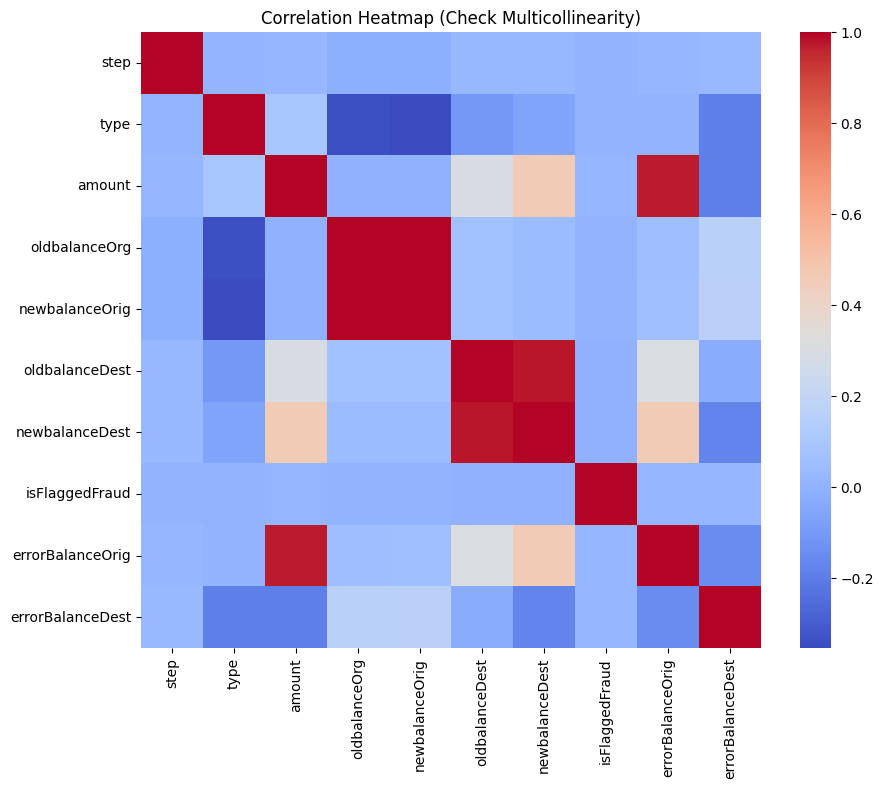

In [27]:
# Handle missing feature values
X = data.drop(['isFraud'], axis=1).fillna(0)
y = data['isFraud']

# Correlation matrix for multicollinearity check
corr = X.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm')
plt.title("Correlation Heatmap (Check Multicollinearity)")
plt.show()

In [28]:
# 4. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [29]:
# Show class distribution before balancing
print("\nClass distribution before SMOTE:")
print(y_train.value_counts())

# Balance dataset with SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Show class distribution after balancing
print("\nClass distribution after SMOTE:")
print(y_train_res.value_counts())


Class distribution before SMOTE:
isFraud
0    5083526
1       6570
Name: count, dtype: int64

Class distribution after SMOTE:
isFraud
0    5083526
1    5083526
Name: count, dtype: int64


In [30]:
# 5. Model Training (Q2)
rf_model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)

print("\nTraining Random Forest...")
rf_model.fit(X_train_res, y_train_res)
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:,1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {auc:.4f}")


Training Random Forest...

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.98      1.00      0.99      1643

    accuracy                           1.00   1272524
   macro avg       0.99      1.00      0.99   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC: 0.9994


In [35]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 1.0000


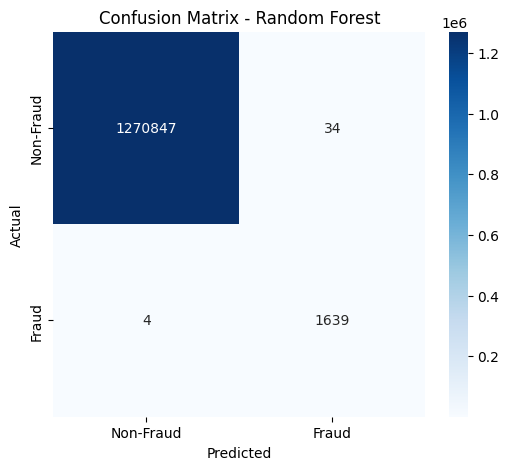

In [37]:
# 6. Confusion Matrix & ROC (Q4)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud','Fraud'], yticklabels=['Non-Fraud','Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

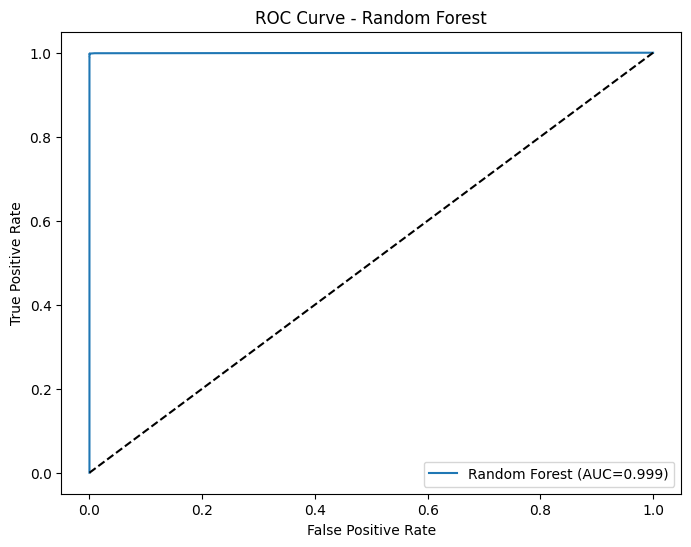

In [31]:
# 6. Model Evaluation (Q4)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()

In [41]:
# 7. Cross-Validation (Checking Overfitting)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)
print("\nCross-Validation ROC-AUC scores:", cv_scores)
print("Mean CV ROC-AUC:", np.mean(cv_scores))


Cross-Validation ROC-AUC scores: [0.99908586 0.99664848 0.99939086 0.99817295 0.99817283]
Mean CV ROC-AUC: 0.9982941946001069



Feature Importances:
 errorBalanceOrig    0.427687
newbalanceOrig      0.182608
oldbalanceOrg       0.136279
amount              0.083656
type                0.065031
errorBalanceDest    0.039740
step                0.028775
newbalanceDest      0.026428
oldbalanceDest      0.008992
isFlaggedFraud      0.000804
dtype: float64


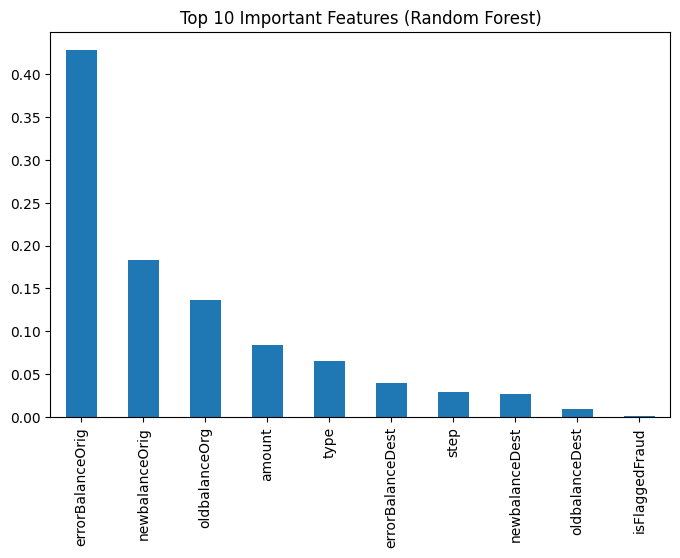

In [32]:
# 7. Feature Selection Insights (Q3)
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importances:\n", importances)

plt.figure(figsize=(8,5))
importances.head(10).plot(kind='bar')
plt.title("Top 10 Important Features (Random Forest)")
plt.show()


KEY FRAUD INDICATORS (Q5)
Transaction Type (TRANSFER, CASH-OUT) highly associated with fraud
Large transaction amounts are riskier
Abnormal balance differences (errorBalanceOrig, errorBalanceDest)

DO THESE FACTORS MAKE SENSE? (Q6)
Yes. Fraudsters often exploit TRANSFER + CASH-OUT to move and withdraw funds quickly.
High amounts are attractive targets. Balance inconsistencies reveal manipulation attempts.

PREVENTION STRATEGIES (Q7)
Flag high-value TRANSFER + CASH-OUT transactions.
Real-time anomaly detection on abnormal balance updates.
Multi-factor authentication for risky transfers.
Daily transaction limits and velocity checks.

VALIDATION OF ACTIONS (Q8)
Compare fraud detection rate before vs. after policies.
Monitor reduction in monetary loss and false positives.